# University of Mannheim
## Data Mining I -- Group Project
### Wine Quality Prediction with SVM
#### Team members:
* Anna-Lena Blinken
* Max Darmstadt
* Nicolas Hautschek
* Erik Penther
* Nicolas Fürhaupter

## Importing Libraries and Data

In [1]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive

In [2]:
# Import libraries

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for the preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Liraries for the model creation
from sklearn import svm  
from sklearn.pipeline import Pipeline

# Libraries for the evaluation
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# Libraries for the model adaption
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE 
from collections import Counter
from sklearn.inspection import permutation_importance
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# Import wine data

wine_data = pd.read_csv('./winequalityN.csv')
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Visualize and Analyse Data

In [4]:
# Print wine data info

wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
# Analyse the data by its mean etc.

wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### Null Values

In [6]:
# Check data for null values

wine_data.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [7]:
# Check class distribution

wine_data.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

### Class Distribution

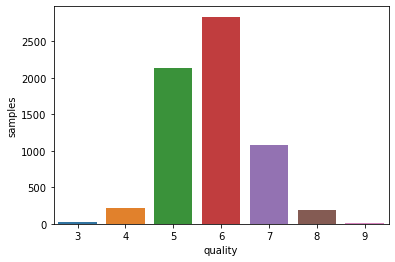

In [8]:
# Visualize class distribution

sns.barplot(x=wine_data.quality.value_counts().index, y=wine_data.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

In [9]:
# Turn 10 classes into 3 classes

wine_data['quality'] = wine_data.quality.apply(lambda x: 2 if x>6 else (1 if x> 4 else 0))

In [10]:
# Check class distribution

wine_data.quality.value_counts()

1    4974
2    1277
0     246
Name: quality, dtype: int64

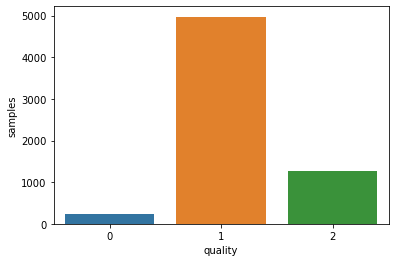

In [11]:
# Visualize class distribution

sns.barplot(x=wine_data.quality.value_counts().index, y=wine_data.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

In [12]:
# Turn 10 classes into 2 classes

wine_data_2 = pd.read_csv('./winequalityN.csv')
wine_data_2['quality'] = wine_data_2.quality.apply(lambda x: 2 if x>5 else 0)

In [13]:
# Check class distribution

wine_data_2.quality.value_counts()

2    4113
0    2384
Name: quality, dtype: int64

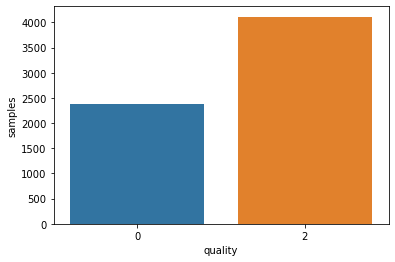

In [14]:
# Visualize class distribution

sns.barplot(x=wine_data_2.quality.value_counts().index, y=wine_data_2.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

### Check duplicates

In [15]:
# Count duplicates and remove duplicates

display(len(wine_data.index))
wine_data.drop_duplicates()
display(len(wine_data.index))

6497

6497

### Unique Values

In [16]:
# Count uniques values of each column

wine_data.nunique()

type                      2
fixed acidity           106
volatile acidity        187
citric acid              89
residual sugar          316
chlorides               214
free sulfur dioxide     135
total sulfur dioxide    276
density                 998
pH                      108
sulphates               111
alcohol                 111
quality                   3
dtype: int64

### Distribution of Values

<AxesSubplot:>

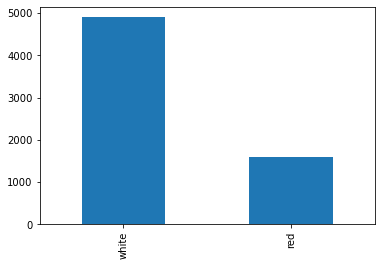

In [17]:
# Plot histogram for each categorical column

wine_data['type'].value_counts().plot(kind='bar')

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

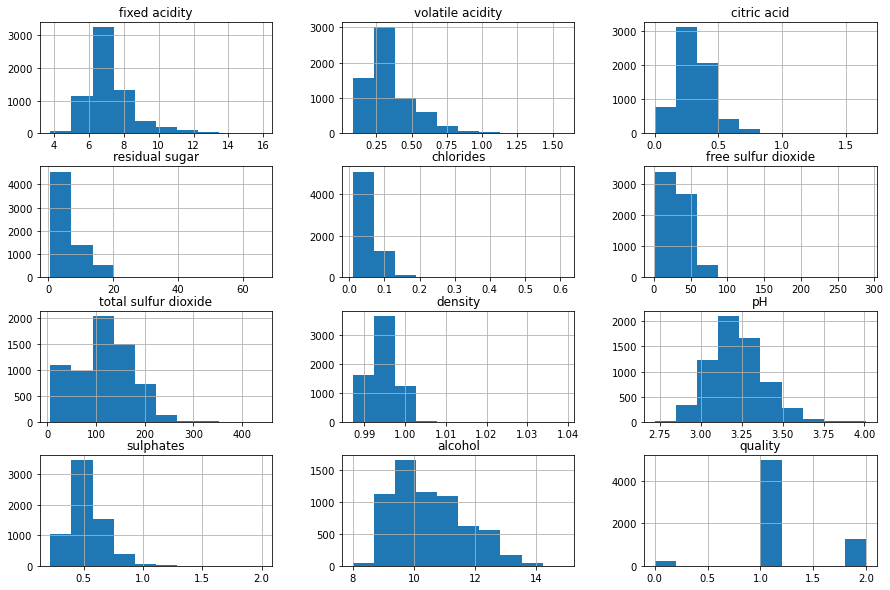

In [18]:
# Plot histogram for each numerical column

wine_data.hist(figsize=(15, 10))

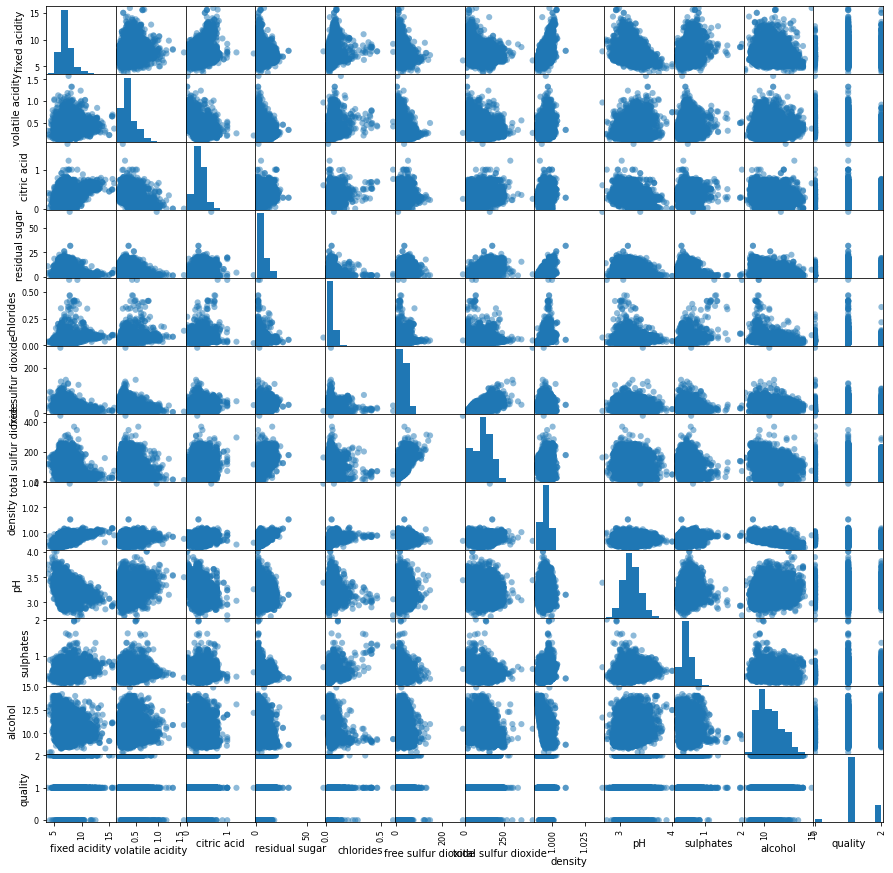

In [19]:
# Plot scatterplots for all possible combinations of columns

pd.plotting.scatter_matrix(wine_data, figsize=(15, 15), s=150);

## Data Cleaning

In [20]:
# Ordinal Encoder for the attribute type

# Show data before preprocessing
display(wine_data.head())

# Create the OrdinalEncoder
ordinal_encoder = preprocessing.OrdinalEncoder()

# Preprocess the categorical feature type
wine_data[['type']] = ordinal_encoder.fit_transform(wine_data[['type']])

# Show the results
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,1.0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,1.0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [21]:
# Normalisation of the numerical values

# Show data before preprocessing
display(wine_data.head())

# Create the normaliser
scaler = preprocessing.MinMaxScaler()

# Preprocess the all numerical features
wine_data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']] = scaler.fit_transform(wine_data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']])

# Show the results
display(wine_data.head())

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,1.0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,1.0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942,1
1,1.0,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391,1
2,1.0,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348,1
3,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,1
4,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,1


In [22]:
# Replace null-values 

# Get column names
column_names = wine_data.columns

# Count null-values
display(wine_data.isnull().sum())
display(len(wine_data.index))

# Data imputation
imp = SimpleImputer(strategy="mean")
wine_data = imp.fit_transform(wine_data)

# Create dataframe from numpy array
wine_data = pd.DataFrame(data=wine_data, columns=column_names)
display(wine_data.isnull().sum())
display(len(wine_data.index))

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

6497

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

6497

## Seperation of features and the target variable and test train split

In [23]:
# Seperation of features and the target variable in two different data frames

wine_data = wine_data.copy()

features = wine_data.drop(columns='quality')
display(features.head())

target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
display(target.head())
target = target['quality'].ravel()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942
1,1.0,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391
2,1.0,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348
3,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362
4,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362


,quality
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [24]:
# Train test split

data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

## Support Vector Machine (SVM)


In [25]:
# Model Creation

# Create svm classifier and pipeline
support_vector_machine = svm.SVC()
pipeline_svm = Pipeline([('estimator', support_vector_machine)])

# Fit the model and predict the values for the train data
pipeline_svm.fit(data_train, target_train)
predictions_train_svm = pipeline_svm.predict(data_train)

### Evaluation

In [26]:
# Predict values for the test data

predictions_test_svm = pipeline_svm.predict(data_test)

#### Makro F1-Score, Makro Precision, and Makro Recall 

In [27]:
# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_svm = f1_score(target_train, predictions_train_svm, average='macro')
display(f1_score_train_svm)

print("Makro F1-Score Test Data:")
f1_score_test_svm = f1_score(target_test, predictions_test_svm, average='macro')
display(f1_score_test_svm)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_svm = precision_score(target_train, predictions_train_svm, average='macro', zero_division = 0)
display(precision_train_svm)

print("Makro Precision Test Data:")
precision_test_svm = precision_score(target_test, predictions_test_svm, average='macro', zero_division = 0)
display(precision_test_svm)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_svm = recall_score(target_train, predictions_train_svm, average='macro')
display(recall_train_svm)

print("Makro Recall Test Data:")
recall_test_svm = recall_score(target_test, predictions_test_svm, average='macro')
display(recall_test_svm)

Makro F1-Score Train Data:


0.39559427298667554

Makro F1-Score Test Data:


0.38708723889568253

Makro Precision Train Data:


0.4966278601480624

Makro Precision Test Data:


0.5095551233367294

Makro Recall Train Data:


0.3926464411552751

Makro Recall Test Data:


0.38690195770519265

#### Confusion Matrix

In [28]:
# Function to plot a confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion Matrix Train Data:


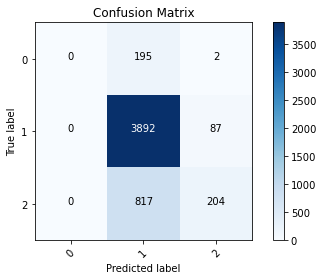

In [29]:
# Confusion Matrix for the training data

cnf_matrix_train_svm = confusion_matrix(target_train, predictions_train_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
plot_confusion_matrix(cnf_matrix_train_svm, classes=np.array([0,1,2]))

Confusion Matrix Test Data:


None

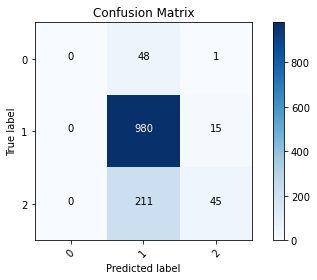

In [30]:
# Confusion Matrix for the test data

cnf_matrix_test_svm = confusion_matrix(target_test, predictions_test_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_svm, classes=np.array([0,1,2])))

## Adoption of the Mode

1. First Hyperparameter Tuning
2. Oversampling (Balancing)
3. Feature Selection
4. Second Hyperparameter Tuning

In each step the best model, which was achieved until that stage, is utilized.

### First Hyperparameter Tuning

- usual parameters to optimize:
  - choice of kernel: `linear`, `rbf`, ...
  - C (Regularization parameter)
  - gamma (Kernel coefficient) for `rbf` and others

In [31]:
# Create an estimator
support_vector_machine = svm.SVC()

# Specify the parameter grid
param_grid = [
  {'C': [1, 10, 100, 1000, 10000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000, 10000], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000, 10000], 'gamma': [1, 0.1, 0.01], 'kernel': ['poly']},
  {'C': [1, 10, 100, 1000, 10000], 'gamma': [1, 0.1, 0.01], 'kernel': ['sigmoid']},
 ]

# Specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the grid search instance
grid_search_estimator_svm = GridSearchCV(support_vector_machine, param_grid, scoring='f1_macro', cv=stratified_10_fold_cv, n_jobs = -1, verbose = 2, return_train_score=False)

# Run the grid search
grid_search_estimator_svm.fit(data_train, target_train)

# Print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator_svm.cv_results_)
display(results)
    
# Print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator_svm.best_score_, grid_search_estimator_svm.best_params_))

Fitting 10 folds for each of 50 candidates, totalling 500 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.153752,0.100167,0.087202,0.002686,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.289034,0.289034,...,0.289034,0.289034,0.289034,0.289034,0.289349,0.289349,0.288937,0.289087,0.000134,26
1,1.064291,0.041257,0.088563,0.003392,10,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.289034,0.289034,...,0.289034,0.289034,0.289034,0.289034,0.289349,0.289349,0.288937,0.289087,0.000134,26
2,7.611830,3.047364,0.097623,0.011910,100,linear,NaN,"{'C': 100, 'kernel': 'linear'}",0.289034,0.289034,...,0.289034,0.289034,0.289034,0.289034,0.289349,0.289349,0.288937,0.289087,0.000134,26
3,172.755084,6.101122,0.082111,0.009217,1000,linear,NaN,"{'C': 1000, 'kernel': 'linear'}",0.289034,0.289034,...,0.289034,0.289034,0.289034,0.289034,0.289349,0.289349,0.288937,0.289087,0.000134,26
4,249.460183,14.863130,0.102025,0.016336,10000,linear,NaN,"{'C': 10000, 'kernel': 'linear'}",0.289034,0.289034,...,0.289034,0.289034,0.289034,0.289034,0.289349,0.289349,0.288937,0.289087,0.000134,26
5,1.968748,0.111800,0.444095,0.050119,1,rbf,1,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.340574,0.367486,...,0.337532,0.349870,0.386140,0.366018,0.355429,0.353883,0.358102,0.357207,0.013240,20
6,1.896978,0.099955,0.450427,0.031280,1,rbf,0.1,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.289034,0.289034,...,0.289034,0.289034,0.289034,0.289034,0.289349,0.289349,0.288937,0.289087,0.000134,26
7,1.632007,0.085460,0.471214,0.050528,1,rbf,0.01,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.289034,0.289034,...,0.289034,0.289034,0.289034,0.289034,0.289349,0.289349,0.288937,0.289087,0.000134,26
8,2.221458,0.114577,0.415385,0.035449,10,rbf,1,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.417411,0.445879,...,0.427258,0.398103,0.442518,0.404888,0.412689,0.415519,0.431600,0.422314,0.014668,12
9,2.140540,0.151532,0.444777,0.089893,10,rbf,0.1,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.289034,0.289034,...,0.289034,0.289034,0.289034,0.289034,0.289349,0.289349,0.288937,0.289087,0.000134,26


best score is 0.533503489739673 with params {'C': 10000, 'gamma': 1, 'kernel': 'poly'}


### Note

Although the first Hyperparameter Tuning led to the optimal parameters of 'kernel' = 'poly', 'C' = 10000 and 'gamma' = 1, a rbf kernel was used for the next step (Model (SVM) with Hyperparameter Tuning). The other hyperparameters weren't changed. This is because the similar hyperparameter combination with a rbf kernel (rank 2) scored nearly as good as the combination with a poly kernel (rank 1). In addition, the rbf kernel generates significantly better Makro F1-Scores during the model evaluation. This was found out via experimentation with the hyperparameters. 

#### Model (SVM) with Hyperparameter Tuning

Makro F1-Score Train Data:


0.712203773048529

Makro F1-Score Test Data:


0.5160367387025229

Makro Precision Train Data:


0.8814609633499803

Makro Precision Test Data:


0.5629241938390853

Makro Recall Train Data:


0.6384323404931279

Makro Recall Test Data:


0.4925958448706116

Confusion Matrix Train Data:


None

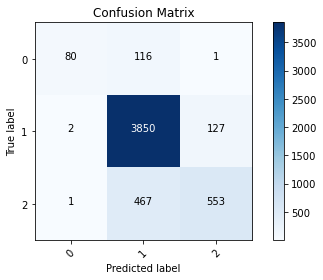

In [32]:
# Changing Hyperparameters 

# Creation of the svm classifier and the pipeline with the new parameters
support_vector_machine = svm.SVC(C=10000, kernel='rbf', gamma=1)
pipeline_svm = Pipeline([('estimator', support_vector_machine)])

# Fit the model and predict the values for the train data
pipeline_svm.fit(data_train, target_train)
predictions_train_svm = pipeline_svm.predict(data_train)

# Predict values for the test data
predictions_test_svm = pipeline_svm.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_svm = f1_score(target_train, predictions_train_svm, average='macro')
display(f1_score_train_svm)

print("Makro F1-Score Test Data:")
f1_score_test_svm = f1_score(target_test, predictions_test_svm, average='macro')
display(f1_score_test_svm)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_svm = precision_score(target_train, predictions_train_svm, average='macro', zero_division = 0)
display(precision_train_svm)

print("Makro Precision Test Data:")
precision_test_svm = precision_score(target_test, predictions_test_svm, average='macro', zero_division = 0)
display(precision_test_svm)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_svm = recall_score(target_train, predictions_train_svm, average='macro')
display(recall_train_svm)

print("Makro Recall Test Data:")
recall_test_svm = recall_score(target_test, predictions_test_svm, average='macro')
display(recall_test_svm)

# Confusion Matrix for the training data
cnf_matrix_train_svm = confusion_matrix(target_train, predictions_train_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_svm, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

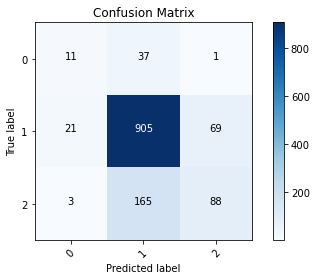

In [33]:
# Confusion Matrix for the test data

cnf_matrix_test_svm = confusion_matrix(target_test, predictions_test_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_svm, classes=np.array([0,1,2])))

### Oversampling (Balancing)

On the basis of the model with the hypertuning of the parameters.

In [34]:
# Run this cell if the package is not installed
# %pip install -q -U imbalanced-learn

Original length of the train dataset (data_train):


5197

Length of target_train:


5197

Class Distribution: Counter({1.0: 3979, 2.0: 1021, 0.0: 197})

Length of balanced train dataset (data_train):


11937

New length of target_train:


11937

New Class Distribution: Counter({1.0: 3979, 2.0: 3979, 0.0: 3979})

Makro F1-Score Train Data:


0.8873773789823316

Makro F1-Score Test Data:


0.5573660527703854

Makro Precision Train Data:


0.8926735005292925

Makro Precision Test Data:


0.5291777105460144

Makro Recall Train Data:


0.8900058641199632

Makro Recall Test Data:


0.6712969609954534

Confusion Matrix Train Data:


None

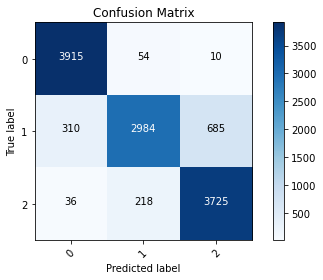

In [35]:
# We use SMOTE to synthesize new examples in the minority class of the train data from the existing examples 

# Print the class distribution before SMOTE
print('Original length of the train dataset (data_train):')
display(len(data_train.index))
print('Length of target_train:')
display(target_train.size)
print('Class Distribution: %s' % Counter(target_train))

# Oversampling 
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Print the new class distribution after SMOTE
print('\nLength of balanced train dataset (data_train):')
display(len(data_train.index))
print('New length of target_train:')
display(target_train.size)
print('New Class Distribution: %s' % Counter(target_train))

# Creation of the new svm classifier and the pipeline
support_vector_machine = svm.SVC(C=10000, kernel='rbf', gamma=1)
pipeline_svm = Pipeline([('estimator', support_vector_machine)])

# Fit the model and predict the values for the train data
pipeline_svm.fit(data_train, target_train)
predictions_train_svm = pipeline_svm.predict(data_train)

# Predict values for the test data
predictions_test_svm = pipeline_svm.predict(data_test)

# Makro F1-Score
print("\nMakro F1-Score Train Data:")
f1_score_train_svm = f1_score(target_train, predictions_train_svm, average='macro')
display(f1_score_train_svm)

print("Makro F1-Score Test Data:")
f1_score_test_svm = f1_score(target_test, predictions_test_svm, average='macro')
display(f1_score_test_svm)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_svm = precision_score(target_train, predictions_train_svm, average='macro', zero_division = 0)
display(precision_train_svm)

print("Makro Precision Test Data:")
precision_test_svm = precision_score(target_test, predictions_test_svm, average='macro', zero_division = 0)
display(precision_test_svm)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_svm = recall_score(target_train, predictions_train_svm, average='macro')
display(recall_train_svm)

print("Makro Recall Test Data:")
recall_test_svm = recall_score(target_test, predictions_test_svm, average='macro')
display(recall_test_svm)

# Confusion Matrix for the training data
cnf_matrix_train_svm = confusion_matrix(target_train, predictions_train_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_svm, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

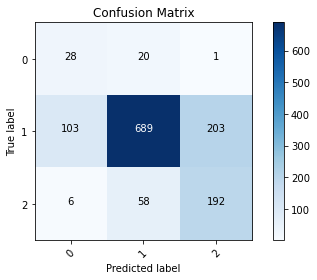

In [36]:
# Confusion Matrix for the test data

cnf_matrix_test_svm = confusion_matrix(target_test, predictions_test_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_svm, classes=np.array([0,1,2])))

### Note

The oversampling with SMOTE was successful because the Makro F1-Score (train/test) of the balanced model could be improved even further. Consequently, this model is used for the next steps (feature selection and second Hyperparameter Tuning). In addition, the model entails two major benefits:   
    
- In the oversampled model, the predictions for classes 0 and 2 became much more accurate (see confusion matrix).
        
- The models previous to oversampling had a heavy tendency/bias to class 1 in the train and test data (see confusion matrix) due to the unbalanced dataset. We want to avoid such bias and keep the model close to the real practice. We do not know if wines outside of our dataset will also mostly fall into the medium category (class 1).  

### Feature Selection

On the basis of the model with the hypertuning of the parameters and the oversampling.

Due to the rbf kernel, the calculation of the feature importance is not possible. 

Text(0.5, 0, 'Permutation Importance')

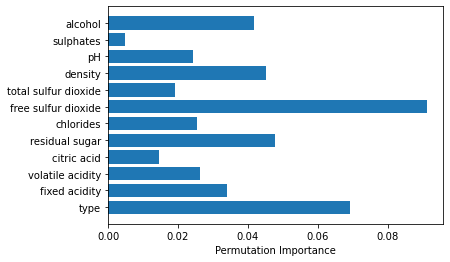

In [37]:
# Permutation Importance

perm_importance = permutation_importance(support_vector_machine, data_test, target_test)
feature_list = list(features)
plt.barh(feature_list, perm_importance.importances_mean)
plt.xlabel("Permutation Importance")

In [38]:
# Feature Correlation

wines = wine_data.copy()
y_ql = wines.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # Get Y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

    # Calculate VIF factors: for each X, calculate VIF and save it in the dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols

vif = VRF('quality', df.loc[:, cols], y_ql)

,VIF Factor,features
0,1.000000,Intercept
13,1.239882,quality
11,1.569112,sulphates
4,1.620315,citric_acid
6,1.659194,chlorides
3,2.215939,volatile_acidity
7,2.243876,free_sulfur_dioxide
10,2.554538,pH
8,4.045689,total_sulfur_dioxide
2,5.034653,fixed_acidity


#### Feature Permutation: Model without sulphates

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,alcohol
0,1.0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.115942
1,1.0,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.217391
2,1.0,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.304348
3,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.275362
4,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.275362



Makro F1-Score Train Data:


0.8552528452871294

Makro F1-Score Test Data:


0.53692071158543

Makro Precision Train Data:


0.8614156423631872

Makro Precision Test Data:


0.5153912037480904

Makro Recall Train Data:


0.858926028315322

Makro Recall Test Data:


0.6547837508118826

Confusion Matrix Train Data:


None

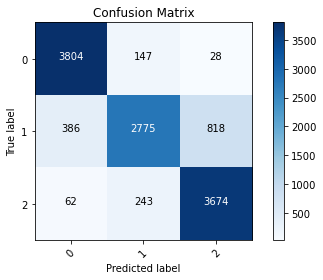

In [39]:
# Seperation of features and the target variable in two different data frames and dropping the columns quality and sulphates
features = wine_data.drop(columns=['quality', 'sulphates'])
display(features.head())
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Creation of the svm classifier and the pipeline
support_vector_machine = svm.SVC(C=10000, kernel='rbf', gamma=1)
pipeline_svm = Pipeline([('estimator', support_vector_machine)])

# Fit the model and predict the values for the train data
pipeline_svm.fit(data_train, target_train)
predictions_train_svm = pipeline_svm.predict(data_train)

# Predict values for the test data
predictions_test_svm = pipeline_svm.predict(data_test)

# Makro F1-Score
print("\nMakro F1-Score Train Data:")
f1_score_train_svm = f1_score(target_train, predictions_train_svm, average='macro')
display(f1_score_train_svm)

print("Makro F1-Score Test Data:")
f1_score_test_svm = f1_score(target_test, predictions_test_svm, average='macro')
display(f1_score_test_svm)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_svm = precision_score(target_train, predictions_train_svm, average='macro', zero_division = 0)
display(precision_train_svm)

print("Makro Precision Test Data:")
precision_test_svm = precision_score(target_test, predictions_test_svm, average='macro', zero_division = 0)
display(precision_test_svm)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_svm = recall_score(target_train, predictions_train_svm, average='macro')
display(recall_train_svm)

print("Makro Recall Test Data:")
recall_test_svm = recall_score(target_test, predictions_test_svm, average='macro')
display(recall_test_svm)

# Confusion Matrix for the training data
cnf_matrix_train_svm = confusion_matrix(target_train, predictions_train_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_svm, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

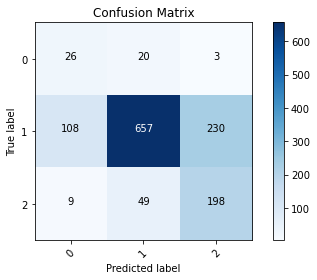

In [40]:
# Confusion Matrix for the test data

cnf_matrix_test_svm = confusion_matrix(target_test, predictions_test_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_svm, classes=np.array([0,1,2])))

#### Feature Correlation:  Model without fixed acidity, alcohol, type, residual sugar, and density

,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates
0,0.126667,0.216867,0.059801,0.152778,0.377880,0.217054,0.129213
1,0.146667,0.204819,0.066445,0.045139,0.290323,0.449612,0.151685
2,0.133333,0.240964,0.068106,0.100694,0.209677,0.418605,0.123596
3,0.100000,0.192771,0.081395,0.159722,0.414747,0.364341,0.101124
4,0.100000,0.192771,0.081395,0.159722,0.414747,0.364341,0.101124



Makro F1-Score Train Data:


0.7425509868662825

Makro F1-Score Test Data:


0.46434013527616314

Makro Precision Train Data:


0.7501998737905228

Makro Precision Test Data:


0.4758594249563503

Makro Recall Train Data:


0.7501884895702439

Makro Recall Test Data:


0.6423764496376441

Confusion Matrix Train Data:


None

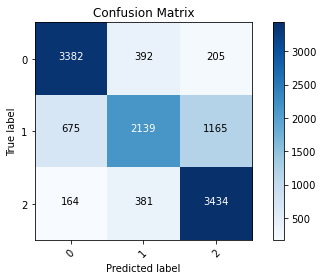

In [41]:
# Seperation of features and the target variable in two different data frames and dropping the columns fixed acidity, alcohol, type, residual sugar, and density
features = wine_data.drop(columns=['quality', 'type', 'fixed acidity', 'alcohol', 'density', 'residual sugar'])
display(features.head())
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Creation of the svm classifier and the pipeline
support_vector_machine = svm.SVC(C=10000, kernel='rbf', gamma=1)
pipeline_svm = Pipeline([('estimator', support_vector_machine)])

# Fit the model and predict the values for the train data
pipeline_svm.fit(data_train, target_train)
predictions_train_svm = pipeline_svm.predict(data_train)

# Predict values for the test data
predictions_test_svm = pipeline_svm.predict(data_test)

# Makro F1-Score
print("\nMakro F1-Score Train Data:")
f1_score_train_svm = f1_score(target_train, predictions_train_svm, average='macro')
display(f1_score_train_svm)

print("Makro F1-Score Test Data:")
f1_score_test_svm = f1_score(target_test, predictions_test_svm, average='macro')
display(f1_score_test_svm)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_svm = precision_score(target_train, predictions_train_svm, average='macro', zero_division = 0)
display(precision_train_svm)

print("Makro Precision Test Data:")
precision_test_svm = precision_score(target_test, predictions_test_svm, average='macro', zero_division = 0)
display(precision_test_svm)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_svm = recall_score(target_train, predictions_train_svm, average='macro')
display(recall_train_svm)

print("Makro Recall Test Data:")
recall_test_svm = recall_score(target_test, predictions_test_svm, average='macro')
display(recall_test_svm)

# Confusion Matrix for the training data
cnf_matrix_train_svm = confusion_matrix(target_train, predictions_train_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_svm, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

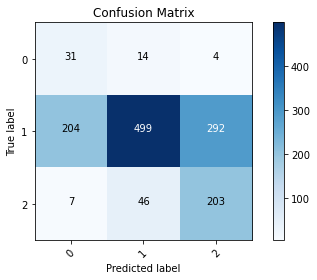

In [42]:
# Confusion Matrix for the test data

cnf_matrix_test_svm = confusion_matrix(target_test, predictions_test_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_svm, classes=np.array([0,1,2])))

### Note

After implementing the Feature Permutation and Feature Correlation, the evaluation metrics could not be further improved. Therefore, we will use the balanced model without dropping any columns or irrelevant attributes for the second hyperparameter tuning. 

### Second Hyperparameter Tuning

In [43]:
# Seperation of features and the target variable in two different data frames
features = wine_data.drop(columns=['quality'])
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Create an estimator
support_vector_machine = svm.SVC()

# Specify the parameter grid
# Due to performance issues, the hyperparameter 'C' = 10000 was left out for 'kernel' = 'poly'
param_grid = [
  {'C': [1, 10, 100, 1000, 10000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000, 10000], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01], 'kernel': ['poly']},
  {'C': [1, 10, 100, 1000, 10000], 'gamma': [1, 0.1, 0.01], 'kernel': ['sigmoid']},
 ]

# Specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the grid search instance
grid_search_estimator_svm = GridSearchCV(support_vector_machine, param_grid, scoring='f1_macro', cv=stratified_10_fold_cv, n_jobs = -1, verbose = 2, return_train_score=False)

# Run the grid search
grid_search_estimator_svm.fit(data_train, target_train)

# Print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator_svm.cv_results_)
display(results)
    
# Print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator_svm.best_score_, grid_search_estimator_svm.best_params_))

Fitting 10 folds for each of 47 candidates, totalling 470 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,8.550088,0.250009,0.624198,0.018090,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.642650,0.644810,...,0.639524,0.624047,0.644072,0.620290,0.632563,0.630742,0.658995,0.641131,0.015195,25
1,10.965799,0.786249,0.648133,0.022011,10,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.649990,0.650455,...,0.642872,0.625272,0.648348,0.616441,0.633123,0.636557,0.668288,0.644822,0.017451,19
2,19.809109,0.635797,0.731970,0.086395,100,linear,NaN,"{'C': 100, 'kernel': 'linear'}",0.648299,0.650271,...,0.635373,0.622761,0.643772,0.613897,0.636899,0.633283,0.666151,0.642320,0.017115,22
3,45.821798,1.651285,0.668490,0.053107,1000,linear,NaN,"{'C': 1000, 'kernel': 'linear'}",0.647823,0.649449,...,0.636198,0.622545,0.647019,0.613450,0.636119,0.630616,0.666053,0.641987,0.017036,23
4,238.462889,8.963955,0.780416,0.137158,10000,linear,NaN,"{'C': 10000, 'kernel': 'linear'}",0.648755,0.652641,...,0.637149,0.622761,0.646219,0.613414,0.635368,0.629868,0.666960,0.642454,0.017504,21
5,13.355630,1.134524,3.334324,0.128682,1,rbf,1,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.684905,0.695019,...,0.686487,0.678305,0.691556,0.691457,0.676808,0.670555,0.695207,0.689376,0.013783,12
6,16.625458,0.903734,3.462033,0.183106,1,rbf,0.1,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.638036,0.646283,...,0.627696,0.620801,0.642356,0.609049,0.642906,0.626996,0.649983,0.636506,0.014564,28
7,17.966454,0.876000,3.513288,0.130640,1,rbf,0.01,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.604076,0.613596,...,0.604202,0.610665,0.615208,0.585128,0.621502,0.589846,0.608697,0.607184,0.011261,33
8,10.173287,0.329174,2.421932,0.164025,10,rbf,1,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.744647,0.730048,...,0.717740,0.724149,0.727414,0.738466,0.723175,0.712013,0.745138,0.732277,0.013870,7
9,12.435081,0.509085,2.813727,0.241467,10,rbf,0.1,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.654865,0.666749,...,0.653099,0.641518,0.657678,0.637714,0.642542,0.653732,0.661412,0.655720,0.013799,17


best score is 0.8527015874656859 with params {'C': 10000, 'gamma': 1, 'kernel': 'rbf'}


#### Model (SVM) with Hyperparameter Tuning (1)

There wasn't any change in the result because the optimal combination of hyperparameters remained the same as above. 

Makro F1-Score Train Data:


0.8873773789823316

Makro F1-Score Test Data:


0.5573660527703854

Makro Precision Train Data:


0.8926735005292925

Makro Precision Test Data:


0.5291777105460144

Makro Recall Train Data:


0.8900058641199632

Makro Recall Test Data:


0.6712969609954534

Confusion Matrix Train Data:


None

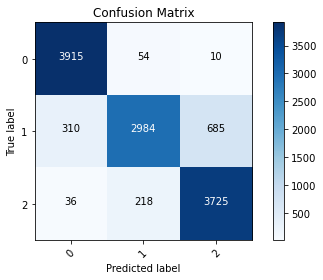

In [44]:
# Changing Hyperparameters 

# Creation of the svm classifier and the pipeline with the new parameters
support_vector_machine = svm.SVC(C=10000, kernel='rbf', gamma=1)
pipeline_svm = Pipeline([('estimator', support_vector_machine)])

# Fit the model and predict the values for the train data
pipeline_svm.fit(data_train, target_train)
predictions_train_svm = pipeline_svm.predict(data_train)

# Predict values for the test data
predictions_test_svm = pipeline_svm.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_svm = f1_score(target_train, predictions_train_svm, average='macro')
display(f1_score_train_svm)

print("Makro F1-Score Test Data:")
f1_score_test_svm = f1_score(target_test, predictions_test_svm, average='macro')
display(f1_score_test_svm)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_svm = precision_score(target_train, predictions_train_svm, average='macro', zero_division = 0)
display(precision_train_svm)

print("Makro Precision Test Data:")
precision_test_svm = precision_score(target_test, predictions_test_svm, average='macro', zero_division = 0)
display(precision_test_svm)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_svm = recall_score(target_train, predictions_train_svm, average='macro')
display(recall_train_svm)

print("Makro Recall Test Data:")
recall_test_svm = recall_score(target_test, predictions_test_svm, average='macro')
display(recall_test_svm)

# Confusion Matrix for the training data
cnf_matrix_train_svm = confusion_matrix(target_train, predictions_train_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_svm, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

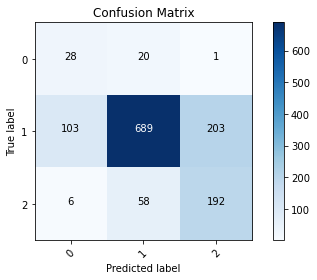

In [45]:
# Confusion Matrix for the test data

cnf_matrix_test_svm = confusion_matrix(target_test, predictions_test_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_svm, classes=np.array([0,1,2])))

#### Model (SVM) with Hyperparameter Tuning (2)

Another model was created for further experimentation with the hyperparameters C and gamma.

Makro F1-Score Train Data:


0.9504712341091744

Makro F1-Score Test Data:


0.5621314440500271

Makro Precision Train Data:


0.9524900468442734

Makro Precision Test Data:


0.5370706359707191

Makro Recall Train Data:


0.9509089385942867

Makro Recall Test Data:


0.6179787115851366

Confusion Matrix Train Data:


None

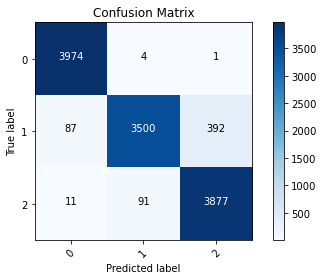

In [46]:
# Changing Hyperparameters 

# Creation of the svm classifier and the pipeline with the new parameters
support_vector_machine = svm.SVC(C=25000, kernel='rbf', gamma=2)
pipeline_svm = Pipeline([('estimator', support_vector_machine)])

# Fit the model and predict the values for the train data
pipeline_svm.fit(data_train, target_train)
predictions_train_svm = pipeline_svm.predict(data_train)

# Predict values for the test data
predictions_test_svm = pipeline_svm.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_svm = f1_score(target_train, predictions_train_svm, average='macro')
display(f1_score_train_svm)

print("Makro F1-Score Test Data:")
f1_score_test_svm = f1_score(target_test, predictions_test_svm, average='macro')
display(f1_score_test_svm)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_svm = precision_score(target_train, predictions_train_svm, average='macro', zero_division = 0)
display(precision_train_svm)

print("Makro Precision Test Data:")
precision_test_svm = precision_score(target_test, predictions_test_svm, average='macro', zero_division = 0)
display(precision_test_svm)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_svm = recall_score(target_train, predictions_train_svm, average='macro')
display(recall_train_svm)

print("Makro Recall Test Data:")
recall_test_svm = recall_score(target_test, predictions_test_svm, average='macro')
display(recall_test_svm)

# Confusion Matrix for the training data
cnf_matrix_train_svm = confusion_matrix(target_train, predictions_train_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_svm, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

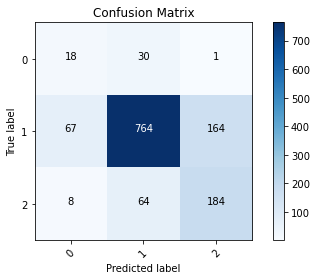

In [47]:
# Confusion Matrix for the test data

cnf_matrix_test_svm = confusion_matrix(target_test, predictions_test_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_svm, classes=np.array([0,1,2])))

### Conclusion

After further experimentation with the hyperparameters 'C' and 'gamma', the best model regarding the Makro F1-Score could be generated. This model is based on the balanced dataset with no feature selection and was tuned with the second hyperparameter tuning. The Makro F1-Score for the train data is 95 %, for the test data it is 56.2 %. In theory, it is possible to further increase the Makro F1-Score for the test data to values above 60 % by increasing the hyperparameters 'C' and 'gamma'. However, this would lead to an even higher overfit-tendency of the model. Therefore, this step was avoided.  